# PyTorch Hypercolumn CNN  for Zurich Dataset

In [1]:
# import libraries
import pandas as pd
import os, sys
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.gaussian_process.kernels import RBF
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
import numpy as np
import gc
from helpers_pytorch import *

# custom libraries
base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code')  # Path to density Tree package
from helpers.data_loader import ZurichLoader
from helpers.helpers import *
from helpers.plots import *
from helpers.parameter_search import *
from hypercolumn import HyperColumn

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # sys.argv[2]

Using TensorFlow backend.


In [2]:
# parameters
base_dir = '/raid/home/cwendl'  # for guanabana
root_dir = base_dir + '/SIE-Master/Zurich'
patch_size = 64
class_to_remove = 8  # int(sys.argv[1])
paramsearch = True  # find best hyperparemeters for ND methods
train_bool = False  # train or load CNN model
my_dpi=255  # screen DPI

# data frame with previously found optimal hyperparameters
df_ps = pd.read_csv('models/hyperparams.csv', index_col=0) 

In [3]:
df_ps

,gmm_n_components,oc-svm_k,oc-svm_deg,oc_svm_nu,df_depth,df_min_ig
Buildings,9,poly,1,0.0010,2,-inf
Trees,8,poly,2,0.0100,2,0.000000
Grass,4,rbf,1,0.5000,3,0.400000
Bare Soil,9,poly,1,0.0001,2,0.000000
Water,3,poly,1,0.5000,1,0.400000
Railways,4,rbf,1,0.0001,1,0.400000
Roads,4,poly,1,0.5000,2,0.700000
Swimming Pools,8,rbf,1,0.5000,3,0.400000


In [4]:
# load datasets
dataset_train = ZurichLoader(root_dir, 'train', patch_size=patch_size, stride=patch_size, transform='augment',
                             class_to_remove=class_to_remove)
dataset_val = ZurichLoader(root_dir, 'val', patch_size=patch_size, stride=patch_size,
                           class_to_remove=class_to_remove)
dataset_test = ZurichLoader(root_dir, 'test', patch_size=patch_size, stride=patch_size,
                            class_to_remove=class_to_remove)

dataloader_train = DataLoader(dataset_train, batch_size=100, shuffle=True, num_workers=20)
dataloader_val = DataLoader(dataset_val, batch_size=100, shuffle=False, num_workers=20)
dataloader_test = DataLoader(dataset_test, batch_size=100, shuffle=False, num_workers=20)

# load patches with overlap (for prediction)
dataset_train_overlap = ZurichLoader(root_dir, 'train', patch_size=patch_size, stride=int(patch_size/2), 
                                     inherit_loader=dataset_train)
dataset_val_overlap = ZurichLoader(root_dir, 'val', patch_size=patch_size, stride=int(patch_size/2), 
                                   inherit_loader=dataset_val)
dataset_test_overlap = ZurichLoader(root_dir, 'test', patch_size=patch_size, stride=int(patch_size/2), 
                                    inherit_loader=dataset_test)

dataloader_train_overlap = DataLoader(dataset_train_overlap, batch_size=100, shuffle=False, num_workers=40)
dataloader_val_overlap = DataLoader(dataset_val_overlap, batch_size=100, shuffle=False, num_workers=40)
dataloader_test_overlap = DataLoader(dataset_test_overlap, batch_size=100, shuffle=False, num_workers=40)

In [5]:
print(dataset_train.im_patches.shape)
print(dataset_train.gt_patches.shape)

(4003, 64, 64, 4)
(4003, 64, 64)


In [6]:
# class names and colors
names = dataset_train.names
colors = dataset_train.colors
n_classes = 9
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])
names_keep = np.asarray(names)[classes_to_keep]
print("classes to keep: " + str(names_keep))

classes to keep: ['Roads' 'Buildings' 'Trees' 'Grass' 'Bare Soil' 'Water' 'Railways']


In [7]:
# train or load CNN model
model = HyperColumn(in_dim=4, out_dim=9, n_filters=32, patch_size=patch_size).cuda()
if train_bool:
    train(model, dataloader_train, dataloader_val, epochs=200, verbosity=1, plot=True, class_to_remove=class_to_remove)
    
    # save model
    state = {'model': model.state_dict(), 
             'n_epochs': 50,
             'loss_tr':0.
            }
    torch.save(state, 'models/model_wo_cl_' + str(class_to_remove) + '.pytorch')
     
else:  # load saved model
    state = torch.load('models/model_wo_cl_' + str(class_to_remove) + '.pytorch')
    model.load_state_dict(state['model'])

In [13]:
# predict

# train
preds_tr = predict_softmax_strides(model, dataset_train, [30, 40, 50], root_dir)
#preds_val = predict_softmax_strides(model, dataset_val, [30, 40, 50], root_dir)
#preds_te = predict_softmax_strides(model, dataset_test, [30, 40, 50], root_dir)

# get labels
pred_labels_tr = get_y_pred_labels(preds_tr, class_to_remove=class_to_remove, background=False)
#pred_labels_val = get_y_pred_labels(preds_val, class_to_remove=class_to_remove, background=False)
#pred_labels_te = get_y_pred_labels(preds_te, class_to_remove=class_to_remove, background=False)

64
creating dataloader with stride 30
(17726, 64, 64, 4)
Making predictions


178it [00:11, 15.05it/s]


creating dataloader with stride 40
(10036, 64, 64, 4)
Making predictions


101it [00:06, 14.87it/s]


creating dataloader with stride 50
(6450, 64, 64, 4)
Making predictions


65it [00:04, 14.87it/s]


# TODO
- During prediction, create patches with overlap and padding using different strides,  return only output within original image

In [15]:
# free GPU memory
while gc.collect():
    torch.cuda.empty_cache()

In [17]:
# get indices of correctly / incorrectly predicted pixels
# train
#pred_t_tr = (dataset_train.gt_patches != class_to_remove) & (dataset_train.gt_patches != 0)
pred_t_tr = pred_labels_tr == dataset_train.gt_patches
pred_f_tr = dataset_train.gt_patches == class_to_remove

# val
#pred_t_val = (dataset_val.gt_patches != class_to_remove) & (dataset_val.gt_patches != 0)
#pred_t_val = pred_labels_val == dataset_val.gt_patches
#pred_f_val = dataset_val.gt_patches == class_to_remove

# test
#pred_t_te = (dataset_test.gt_patches != class_to_remove) & (dataset_test.gt_patches != 0)
#pred_t_te = pred_labels_te == dataset_test.gt_patches
#pred_f_te = dataset_test.gt_patches == class_to_remove

In [22]:
np.unique(pred_labels_tr)

array([1, 2, 3, 4, 5, 6, 7])

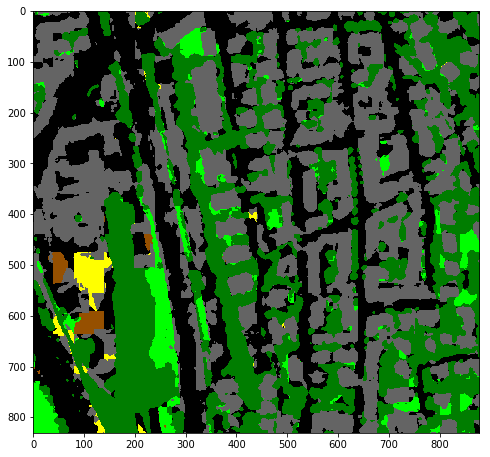

In [29]:
img_idx = 1

img = convert_patches_to_image(dataset_train.imgs, pred_labels_tr[..., np.newaxis], patch_size, patch_size)

# pred
plt.figure(figsize=(8, 8))
plt.imshow(gt_label_to_color(np.squeeze(img[img_idx]), dataset_train.colors)*255)

In [13]:
# export predicted images
offset = 0
for dataset, preds in zip([dataset_train, dataset_val, dataset_test], [pred_labels_tr, pred_labels_val, pred_labels_te]):
    for im_idx in range(len(dataset.imgs)):
        im = convert_patches_to_image(dataset.imgs, preds[..., np.newaxis], im_idx, 64, 64, 0)
        im_color = gt_label_to_color(im, colors) * 255
        f_name = "Figures/Im_pred/cl_" + str(class_to_remove)
        f_name = f_name + "/Im_" + str(im_idx + offset) + "_wo_cl_" + str(class_to_remove) + ".jpg"
        export_figure_matplotlib(im_color, f_name, dpi=my_dpi)
        
    offset += len(dataset.imgs)

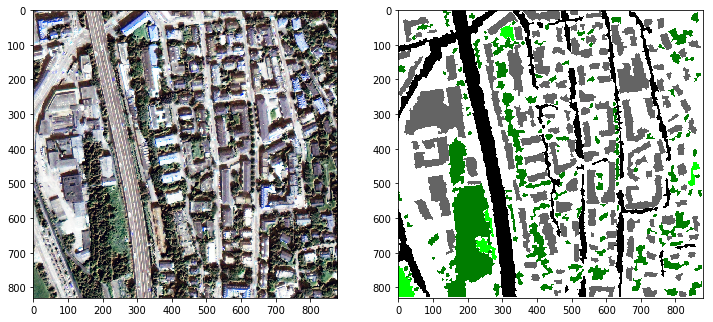

In [14]:
# im
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].imshow(dataset_train.imgs[img_idx][..., :3])
axes[1].imshow(gt_label_to_color(dataset_train.gt[img_idx], dataset_train.colors)*255)

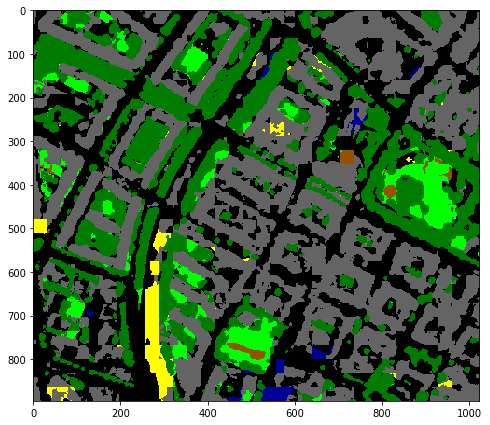

In [15]:
img_idx = 2

img = convert_patches_to_image(dataset_val.imgs, pred_labels_val[..., np.newaxis], img_idx, patch_size, patch_size, 0)

# pred
plt.figure(figsize=(8, 8))
plt.imshow(gt_label_to_color(img, dataset_val.colors)*255)

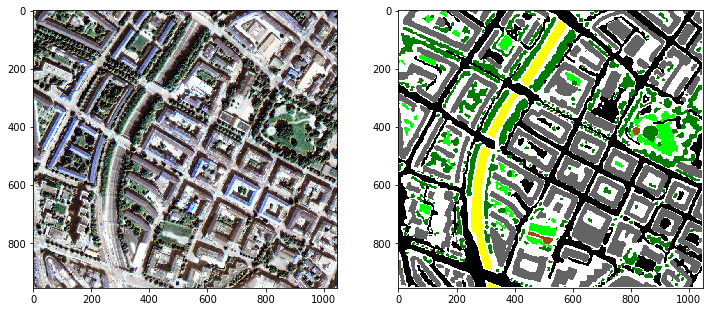

In [16]:
# im
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].imshow(dataset_val.imgs[img_idx][..., :3])
axes[1].imshow(gt_label_to_color(dataset_val.gt[img_idx], dataset_val.colors)*255)

([<matplotlib.axis.XTick at 0x7f450c110be0>,
 <a list of 9 Text xticklabel objects>)

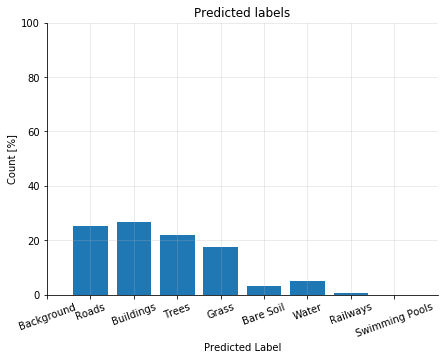

In [17]:
# distribution of predicted labels in test set
pred_labels, pred_counts = np.unique(pred_labels_te, return_counts=True)
pred_counts = pred_counts / sum(pred_counts) * 100

# visualization
fig = plt.figure(figsize=(7, 5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0, 10))
plt.ylim([0, 100])
plt.xlabel("Predicted Label")
plt.ylabel("Count [%]")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.title("Predicted labels")
plt.xticks(np.arange(len(names)), names, rotation=20)

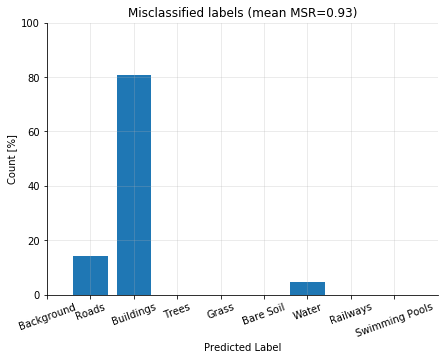

In [18]:
# distribution of predicted label that were misclassified
pred_labels, pred_counts = np.unique(pred_labels_te[pred_f_te], return_counts=True)
pred_counts = pred_counts / sum(pred_counts) * 100

# visualization
fig = plt.figure(figsize=(7, 5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0, 10))
plt.ylim([0, 100])
plt.xlabel("Predicted Label")
plt.ylabel("Count [%]")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.title("Misclassified labels (mean MSR=%.2f)" % np.mean(get_acc_net_msr(preds_te[pred_f_te])))
plt.xticks(np.arange(len(names)), names, rotation=20)
plt.savefig("Figures/Pred_count/ZH_pred-count_wo_cl" + str(class_to_remove) + ".pdf",
            bbox_inches='tight', pad_inches=0)

In [19]:
# TODO get weights
# p = [p for p in model.parameters()]
# for p_ in p:
    # print(p_.cpu().detach().numpy().shape)

In [20]:
ones = np.ones(len(np.unique(dataset_train.gt_patches)))
ones[0] = 0
weight = torch.from_numpy(ones).float().cuda()
f_loss = nn.CrossEntropyLoss(weight=weight)
p = test(model, f_loss, dataloader_train, "Train", verbosity=1)
p = test(model, f_loss, dataloader_val, "Val", verbosity=1)
p = test(model, f_loss, dataloader_test, "Test", verbosity=1)

Train set: Average loss: 0.0158, Accuracy: 83.35%
Val set: Average loss: 0.0164, Accuracy: 77.67%
Test set: Average loss: 0.0161, Accuracy: 78.32%


In [21]:
# Accuracy measures for each class
y_preds = [pred_labels_tr, pred_labels_val, pred_labels_te]
datasets = [dataset_train, dataset_val, dataset_test]

aa_sets, oa_sets = [], []
for y_pred, y_true in zip(y_preds, datasets):
    y_pred_flattened = np.asarray(y_pred.flatten()).astype('int') 
    y_true_flattened = np.asarray(y_true.gt_patches.flatten()).astype('int') 

    # mask background and removed classes for evaluation metrics
    filter_items = (y_true_flattened != 0) & (y_true_flattened != class_to_remove)
    
    aa_set, _ = aa(y_true_flattened[filter_items], y_pred_flattened[filter_items])
    oa_set = oa(y_true_flattened[filter_items], y_pred_flattened[filter_items])
    print("OA: %.3f, AA: %.3f" % (oa_set, aa_set))  # slightly higher accuracy because of overlapping patches
    oa_sets.append(oa_set)
    aa_sets.append(aa_set)

OA: 0.859, AA: 0.827
OA: 0.796, AA: 0.700
OA: 0.806, AA: 0.667


In [22]:
# TODO save CSV
# write metrics to CSV files
df_metrics = pd.read_csv('models/metrics_ND.csv', index_col=0)
accs = np.concatenate([[oa_sets[i], aa_sets[i]] for i in range(3)])  # [oa, aa] for tr, val, te
df2 = pd.DataFrame({str(names[class_to_remove]):accs},
                   index = ['OA Train', 'AA Train', 'OA Val', 'AA Val', 'OA Test', 'AA Test']).T
df_metrics = df_metrics.append(df2)
df_metrics = df_metrics[~df_metrics.index.duplicated(keep='last')]  # avoid duplicates
df_metrics.to_csv('models/metrics_ND.csv')
print((df_metrics*100).round(2).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  OA Train &  AA Train &  OA Val &  AA Val &  OA Test &  AA Test \\
\midrule
[['Background' 'Roads' 'Buildings' 'Trees' 'Gra... &     83.47 &     87.14 &   80.04 &   83.27 &    77.49 &    80.74 \\
Buildings                                          &     87.81 &     83.72 &   83.00 &   70.16 &    79.08 &    67.24 \\
Trees                                              &     76.21 &     76.58 &   73.10 &   74.40 &    73.85 &    73.60 \\
Grass                                              &     84.07 &     87.20 &   79.70 &   74.43 &    81.91 &    70.23 \\
Bare Soil                                          &     81.96 &     84.32 &   80.04 &   81.94 &    80.91 &    81.96 \\
Water                                              &     80.21 &     73.87 &   75.58 &   64.21 &    78.16 &    62.23 \\
Railways                                           &     84.18 &     82.31 &   79.66 &   78.31 &    79.11 &    76.03 \\
Roads                                        

# Network

In [23]:
# precision-recall curves
y_true = pred_f_te.flatten()

# msr
y_scores = (-get_acc_net_msr(preds_te)).flatten()
precision_msr, recall_msr, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_msr = metrics.average_precision_score(y_true, y_scores)
auroc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = (-get_acc_net_max_margin(preds_te)).flatten()
precision_margin, recall_margin, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_margin = metrics.average_precision_score(y_true, y_scores)
auroc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = (-get_acc_net_entropy(preds_te)).flatten()
precision_entropy, recall_entropy, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_entropy = metrics.average_precision_score(y_true, y_scores)
auroc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_msr, pr_auc_msr))
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_margin, pr_auc_margin))
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_entropy, pr_auc_entropy))

AUROC: 0.44, PR AUC: 0.00
AUROC: 0.44, PR AUC: 0.00
AUROC: 0.43, PR AUC: 0.00


In [24]:
# visualization
# MSR
probas_patches_msr = np.reshape((get_acc_net_msr(preds_te)).flatten(), np.shape(dataset_test.gt_patches))
probas_patches_msr -= np.min(probas_patches_msr)
probas_patches_msr /= np.max(probas_patches_msr)

# margin
probas_patches_margin = np.reshape((get_acc_net_max_margin(preds_te)).flatten(), np.shape(dataset_test.gt_patches))
probas_patches_margin -= np.min(probas_patches_margin)
probas_patches_margin /= np.max(probas_patches_margin)

# entropy
probas_patches_entropy = np.reshape((get_acc_net_entropy(preds_te)).flatten(), np.shape(dataset_test.gt_patches))
probas_patches_entropy -= np.min(probas_patches_entropy)
probas_patches_entropy /= np.max(probas_patches_entropy)

In [25]:
base_folder = "Figures/Im_cert/cl_" + str(class_to_remove)

# export images
for img_idx in range(len(dataset_test.imgs)):
    im = dataset_test.imgs[img_idx]
    
    # msr
    acc_im_msr = convert_patches_to_image(dataset_test.imgs, probas_patches_msr[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_msr = exposure.equalize_hist(acc_im_msr)
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_msr_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_msr, f_name, dpi=my_dpi)
    
    # margin
    acc_im_margin = convert_patches_to_image(dataset_test.imgs, probas_patches_margin[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_margin = exposure.equalize_hist(acc_im_margin)
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_margin_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_margin, f_name, dpi=my_dpi)
    
    # entropy
    acc_im_entropy = convert_patches_to_image(dataset_test.imgs, probas_patches_entropy[..., np.newaxis],
                                              img_idx, 64, 64, 0)
    acc_im_entropy = exposure.equalize_hist(acc_im_entropy)
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_entropy_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_entropy, f_name, dpi=my_dpi)

# Dropout

In [26]:
# get softmax scores with dropout
n_iters = 10
probas_dropout = predict_softmax_w_dropout(model, dataloader_test, n_iters)

100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


AUROC: 0.29, PR AUC: 0.00


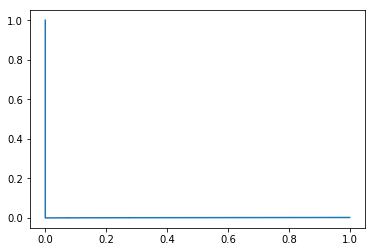

In [27]:
# metrics
y_scores = -get_acc_net_entropy(np.mean(probas_dropout, 0)).flatten()

# PR
precision_dropout, recall_dropout, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_dropout = metrics.auc(recall_dropout, precision_dropout)

# ROC
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, y_scores)
auroc_dropout = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_dropout, precision_dropout)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_dropout, pr_auc_dropout))

In [28]:
# clear CUDA storage
while gc.collect():
    torch.cuda.empty_cache()

In [29]:
# visualization
probas_patches_dropout = np.reshape(y_scores, np.shape(dataset_test.gt_patches))
probas_patches_dropout -= np.min(probas_patches_dropout)
probas_patches_dropout /= np.max(probas_patches_dropout)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(dataset_test.imgs)):
    acc_im_dropout = convert_patches_to_image(dataset_test.imgs, -probas_patches_dropout[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_dropout = exposure.equalize_hist(acc_im_dropout)
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_dropout_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_dropout, f_name, dpi=my_dpi)

# Retrieve Activations

In [30]:
dataset_test.gt_patches.shape

(1185, 64, 64)

In [31]:
act_val = get_activations(model, dataloader_val_overlap)

47it [00:07,  6.22it/s]


In [32]:
del dataset_val_overlap, dataloader_val_overlap

## PCA

In [33]:
# python libraries
from sklearn.manifold import TSNE
from sklearn import decomposition, svm, preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.gaussian_process.kernels import RBF
from sklearn import metrics

# custom libraries
from density_forest.density_forest import *
from density_forest.helpers import *

from helpers.parameter_search import *
from helpers.plots import *

In [34]:
ind_bal = get_balanced_subset_indices(dataset_test.gt_patches.flatten(), np.arange(1, 9)).flatten()

In [35]:
act_val = np.concatenate(np.concatenate(act_val))

In [36]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=.95)
pca.fit(act_val)
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

Variance explained by first 11 components: 0.95


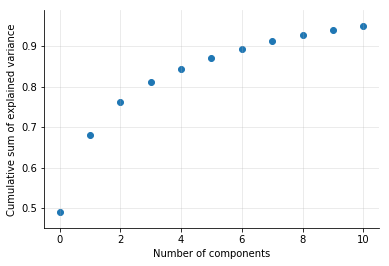

In [37]:
# Plot cumulative explained variance
fig = plt.figure()
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.savefig("Figures/PCA/pca_components_wo_cl_" + str(class_to_remove) + ".pdf",
            bbox_inches='tight', pad_inches=0)

In [38]:
pca = decomposition.PCA(n_components=10)
pca.fit(act_val)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [39]:
act_val = pca.transform(act_val)

In [40]:
# get other activations

# test
act_test = get_activations(model, dataloader_test_overlap)
act_test = np.concatenate(np.concatenate(act_test))
print(np.shape(act_test))
act_test = pca.transform(act_test)
print(np.shape(act_test))

del dataloader_test_overlap, dataset_test_overlap

48it [00:08,  5.65it/s]


(4853760, 30)
(4853760, 10)


In [41]:
# t-SNE visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_all = tsne.fit_transform(act_test[ind_bal])
tsne_y = dataset_test.gt_patches.flatten()[ind_bal]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.001s...
[t-SNE] Computed neighbors for 800 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 0.023737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.567841
[t-SNE] Error after 500 iterations: 0.609842


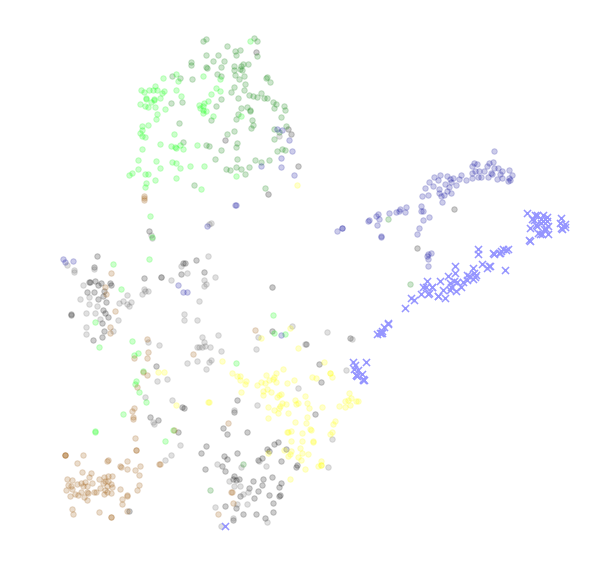

In [42]:
# plot
_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_axis_off()
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, colors, class_to_remove=class_to_remove)
plt.savefig("Figures/tSNE/t-SNE_" + str(names[class_to_remove]).lower().replace(" ", "") + "_after_PCA.pdf",
            bbox_inches='tight', pad_inches=0)

In [43]:
# clear CUDA storage
while gc.collect():
    torch.cuda.empty_cache()

In [44]:
# get other activations

# train
act_train = get_activations(model, dataloader_train_overlap)
act_train = np.concatenate(np.concatenate(act_train))
act_train = pca.transform(act_train)
print(act_train.shape)

145it [00:21,  6.76it/s]


(14831616, 10)


In [45]:
del dataset_train_overlap, dataloader_train_overlap

In [46]:
# clear CUDA storage
while gc.collect():
    torch.cuda.empty_cache()

# Confidence Estimation using Network Embeddings

In [47]:
# parameter search
if paramsearch:
    tuned_parameters = [{'n_components': np.arange(3, 10), 'max_iter': [10000]}]
    # do parameter search
    ps_gmm = ParameterSearch(GaussianMixture, tuned_parameters, act_train[pred_t_tr.flatten()], act_train,
                             pred_f_tr.flatten(), scorer_roc_probas_gmm, 
                             n_iter=3, verbosity=10, n_jobs=-1, subsample_train=.01, subsample_test=.001)
    ps_gmm.fit()
    best_params_gmm = ps_gmm.best_params
else:
    best_params_gmm = {'n_components': df_ps.loc[str(names[class_to_remove])]['gmm_n_components'], 'max_iter': 10000}
print(best_params_gmm)

Trying parameters: {'max_iter': 10000, 'n_components': 3}
Trying parameters: {'max_iter': 10000, 'n_components': 4}
Trying parameters: {'max_iter': 10000, 'n_components': 5}


[Parallel(n_jobs=40)]: Done   1 tasks      | elapsed:   21.3s


Trying parameters: {'max_iter': 10000, 'n_components': 6}
Trying parameters: {'max_iter': 10000, 'n_components': 7}


[Parallel(n_jobs=40)]: Done   2 out of   7 | elapsed:   31.1s remaining:  1.3min


Trying parameters: {'max_iter': 10000, 'n_components': 8}


[Parallel(n_jobs=40)]: Done   3 out of   7 | elapsed:   36.4s remaining:   48.5s


Trying parameters: {'max_iter': 10000, 'n_components': 9}


[Parallel(n_jobs=40)]: Done   4 out of   7 | elapsed:   45.4s remaining:   34.0s
[Parallel(n_jobs=40)]: Done   5 out of   7 | elapsed:  1.0min remaining:   24.0s
[Parallel(n_jobs=40)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=40)]: Done   7 out of   7 | elapsed:  1.2min finished


{'max_iter': 10000, 'n_components': 8}


# GMM

In [48]:
# Fit GMM
gmm = GaussianMixture(**best_params_gmm)
gmm.fit(draw_subsamples(act_train[pred_t_tr.flatten()], .01))

# Predict
probas_gmm = gmm.predict_proba(act_test)
probas_gmm = get_acc_net_entropy(probas_gmm)

AUROC: 0.22, PR AUC: 0.00


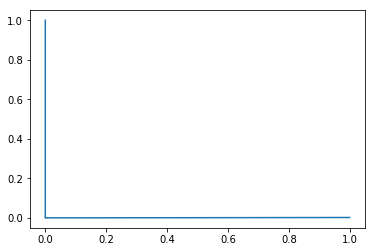

In [49]:
# metrics
y_true = pred_f_te.flatten()
y_scores = -probas_gmm

# PR
precision_gmm, recall_gmm, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_gmm = metrics.auc(recall_gmm, precision_gmm)

# ROC
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, y_scores)
auroc_gmm = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_gmm, precision_gmm)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_gmm, pr_auc_gmm))

In [50]:
# visualization
probas_patches_gmm = np.reshape(y_scores, np.shape(dataset_test.gt_patches))
probas_patches_gmm -= np.min(probas_patches_gmm)
probas_patches_gmm /= np.max(probas_patches_gmm)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(dataset_test.imgs)):
    acc_im_gmm = convert_patches_to_image(dataset_test.imgs, probas_patches_gmm[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_gmm = exposure.equalize_hist(acc_im_gmm)
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_gmm_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_gmm, f_name, dpi=my_dpi)

# SVM

In [51]:
act_train_svm = preprocessing.scale(act_train)
act_val_svm = preprocessing.scale(act_val)
act_test_svm = preprocessing.scale(act_test)

In [52]:
# parameter search
if paramsearch:
    tuned_parameters = [{'kernel': ['rbf'],
                         'nu': [1e-4, 1e-3, 1e-2, 1e-1, 5e-1],
                         'degree': [1]
                         },
                        {'kernel': ['poly'],
                         'degree': np.arange(1, 4),
                         'nu': [1e-4, 1e-3, 1e-2, 1e-1, 5e-1],
                         'max_iter': [10000]}]

    # do parameter search
    ps_svm = ParameterSearch(svm.OneClassSVM, tuned_parameters, act_train_svm[pred_t_tr.flatten()], act_train_svm,
                             pred_f_tr.flatten(), scorer_roc_probas_svm, n_iter=5,
                             verbosity=11, n_jobs=-1, subsample_train=.0001, subsample_test=.001)
    ps_svm.fit()
    best_params_svm = ps_svm.best_params
else:
    best_params_svm = {'kernel': df_ps.loc[str(names[class_to_remove])]['oc-svm_k'], 
                       'degree': df_ps.loc[str(names[class_to_remove])]['oc-svm_deg'], 
                       'nu': df_ps.loc[str(names[class_to_remove])]['oc_svm_nu'],
                       'max_iter':10000}
    
print(best_params_svm)

Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.0001}
Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.001}


[Parallel(n_jobs=40)]: Done   1 tasks      | elapsed:   36.5s


Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.01}
Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.1}


[Parallel(n_jobs=40)]: Done   3 out of  20 | elapsed:   42.7s remaining:  4.0min


Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.5}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}


[Parallel(n_jobs=40)]: Done   5 out of  20 | elapsed:   50.2s remaining:  2.5min


Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


[Parallel(n_jobs=40)]: Done   7 out of  20 | elapsed:   55.8s remaining:  1.7min


Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


[Parallel(n_jobs=40)]: Done   9 out of  20 | elapsed:  1.1min remaining:  1.3min


Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}


[Parallel(n_jobs=40)]: Done  11 out of  20 | elapsed:  1.2min remaining:   56.7s


Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


[Parallel(n_jobs=40)]: Done  13 out of  20 | elapsed:  1.3min remaining:   40.8s


Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}


[Parallel(n_jobs=40)]: Done  15 out of  20 | elapsed:  1.4min remaining:   27.5s


Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


[Parallel(n_jobs=40)]: Done  17 out of  20 | elapsed:  1.5min remaining:   15.6s


Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


[Parallel(n_jobs=40)]: Done  20 out of  20 | elapsed:  1.6min finished


{'degree': 1, 'kernel': 'rbf', 'nu': 0.5}


In [53]:
# Fit SVM
max_dim = 5  # limit to 5 components
clf_svm = svm.OneClassSVM(**best_params_svm)
clf_svm.fit(draw_subsamples(act_train_svm[pred_t_tr.flatten(), :max_dim], .001))

OneClassSVM(cache_size=200, coef0=0.0, degree=1, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [54]:
# predict
probas_svm = clf_svm.decision_function(act_test_svm[..., :max_dim])
probas_svm -= np.min(probas_svm)
probas_svm /= np.max(probas_svm)

In [55]:
# metrics

y_scores = -probas_svm[:]
# PR
precision_svm, recall_svm, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)

# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, y_scores)
auroc_svm = metrics.roc_auc_score(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_svm, pr_auc_svm))

AUROC: 0.96, PR AUC: 0.45


In [56]:
# visualization
probas_patches_svm = np.reshape(probas_svm, np.shape(dataset_test.gt_patches))

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(dataset_test.imgs)):
    acc_im_svm = convert_patches_to_image(dataset_test.imgs, probas_patches_svm[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_svm = exposure.equalize_hist(acc_im_svm)
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_svm_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_svm, f_name, dpi=my_dpi)

#### Visualize Kernels

In [57]:
subset_ind = get_balanced_subset_indices(dataset_train.gt_patches.flatten(), classes_to_keep, pts_per_class=150)

subsample = act_train_svm[np.concatenate(subset_ind)]

In [58]:
# RBF
K = RBF()
K_X = K.__call__(subsample)
K_X = exposure.equalize_hist(K_X)
f_name = "Figures/Kernels/Kernel_RBF_wo_cl_" + str(class_to_remove) + ".jpg" 
export_figure_matplotlib(K_X, f_name, dpi=my_dpi)

# polynomial
for deg in [1, 2, 3]:
    K_X = metrics.pairwise.polynomial_kernel(subsample, degree=deg)
    # contrast stretching
    p2, p98 = np.percentile(K_X, (2, 98))
    K_X = exposure.rescale_intensity(K_X, in_range=(p2, p98))

    f_name = "Figures/Kernels/Kernel_poly_wo_cl_" + str(class_to_remove) + "_deg_" + str(deg) + ".jpg"
    export_figure_matplotlib(K_X, f_name, dpi=my_dpi)

## Density Forest

In [59]:
# parameter search
default_params = {'n_trees': 5, 'n_max_dim': 0, 'n_jobs': -1, 
                  'verbose': 0, 'subsample_pct': .0002, 'min_subset': 1e-3}

if paramsearch:
    """search for best hyperparameters"""
    tuned_params = [{'max_depth': [1, 2, 3],
                     'ig_improvement': [-np.infty, 0, .4, .7]
                    }]

    # do parameter search
    ps_df = ParameterSearch(DensityForest, tuned_params, act_train[pred_t_tr.flatten()], act_train,
                            pred_f_tr.flatten(), scorer_roc_probas_df,
                            n_iter=3, verbosity=11, n_jobs=1, subsample_train=1, 
                            subsample_test=.001, default_params=default_params)

    print("Testing %i combinations %i times" % (len(ps_df.combinations), ps_df.n_iter))
    print(ps_df.combinations)
    ps_df.fit()
    print(ps_df.best_params)
    
    # Create DensityForest instance
    best_params_df = ps_df.best_params
    
else:
    """use previously found hyperparameters"""
    best_params_df = {'max_depth': df_ps.loc[str(names[class_to_remove])]['df_depth'],
                      'ig_improvement': df_ps.loc[str(names[class_to_remove])]['df_min_ig']}
    
    
print(best_params_df)
default_params['verbose'] = 1
default_params['batch_size'] = 10000

Testing 12 combinations 3 times
[{'ig_improvement': -inf, 'max_depth': 1}
 {'ig_improvement': -inf, 'max_depth': 2}
 {'ig_improvement': -inf, 'max_depth': 3}
 {'ig_improvement': 0, 'max_depth': 1}
 {'ig_improvement': 0, 'max_depth': 2}
 {'ig_improvement': 0, 'max_depth': 3}
 {'ig_improvement': 0.4, 'max_depth': 1}
 {'ig_improvement': 0.4, 'max_depth': 2}
 {'ig_improvement': 0.4, 'max_depth': 3}
 {'ig_improvement': 0.7, 'max_depth': 1}
 {'ig_improvement': 0.7, 'max_depth': 2}
 {'ig_improvement': 0.7, 'max_depth': 3}]
Trying parameters: {'ig_improvement': -inf, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.5s remaining:    0.0s


Trying parameters: {'ig_improvement': -inf, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


Trying parameters: {'ig_improvement': -inf, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.8min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.5min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.6min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  5.1min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.9min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  7.0min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.7, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.5min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.7, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.0002, 'verbose': 0}
Trying parameters: {'ig_improvement': 0.7, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.0002, 'verbose': 0}
{'ig_improvement': 0.4, 'max_depth': 3}
{'ig_improvement': 0.4, 'max_depth': 3}


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  9.3min finished


In [60]:
# Create DensityForest instance
default_params['verbose'] = 1
default_params['batch_size'] = 10000
clf_df = DensityForest(**best_params_df, **default_params)
clf_df.fit(act_train[pred_t_tr.flatten()])

probas_df = clf_df.predict(act_test)

Number of points on which to train each tree: 1464
Minimum number of points in each leaf: 1


[Parallel(n_jobs=40)]: Done   5 out of   5 | elapsed:   16.9s finished


Number of created root nodes: 5
Mean number of clusters created per tree: 15
Total steps: 485
Number of jobs: 40 


[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    5.3s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   14.9s
[Parallel(n_jobs=40)]: Done 484 out of 484 | elapsed:   18.8s finished


In [61]:
# metrics
y_scores = -probas_df

# PR
precision_df, recall_df, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_df = metrics.auc(recall_df, precision_df)

# ROC
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
auroc_df = metrics.roc_auc_score(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_df, pr_auc_df))

AUROC: 0.92, PR AUC: 0.24


In [62]:
# visualization
probas_patches_df = np.reshape(y_scores, np.shape(dataset_test.gt_patches))
probas_patches_df -= np.min(probas_patches_df)
probas_patches_df /= np.max(probas_patches_df)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(dataset_test.imgs)):
    acc_im_df = convert_patches_to_image(dataset_test.imgs, probas_patches_df[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_df = exposure.equalize_hist(acc_im_df)
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_df_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_df, f_name, dpi=my_dpi)

# Plots

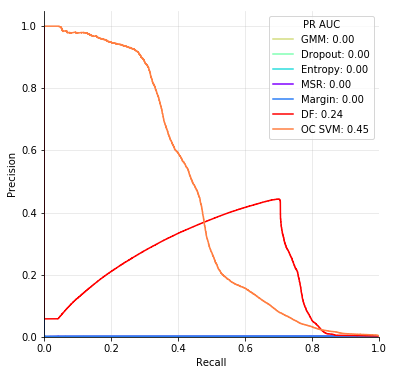

In [63]:
# Precision-Recall Curve
# order according to increasing score
scores_pr = [pr_auc_msr, pr_auc_margin, pr_auc_entropy, pr_auc_dropout, pr_auc_gmm, pr_auc_svm, pr_auc_df]

recalls = [recall_msr, recall_margin, recall_entropy, recall_dropout, recall_gmm, recall_svm, recall_df]
precisions = [precision_msr, precision_margin, precision_entropy, precision_dropout, 
              precision_gmm, precision_svm, precision_df]

names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'OC SVM', 'DF'])
scores_order = np.argsort(scores_pr)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_pr)))[:, :3]

# plot
fig = plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(recalls[i], precisions[i], where='post', c=colors_lines[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_pr[i]) for i in scores_order], title="PR AUC")
plt.savefig("Figures/Metrics/PR_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

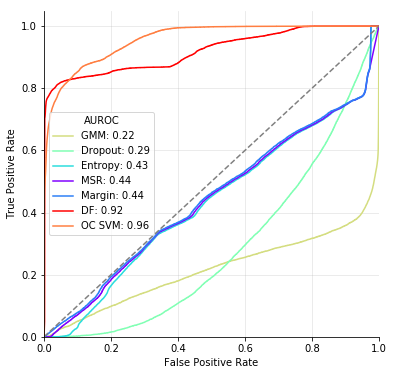

In [64]:
# ROC
# order according to increasing score
scores_auc = [auroc_msr, auroc_margin, auroc_entropy, auroc_dropout, auroc_gmm, auroc_svm, auroc_df]
fprs = [fpr_msr, fpr_margin, fpr_entropy, fpr_dropout, fpr_gmm, fpr_svm, fpr_df]
tprs = [tpr_msr, tpr_margin, tpr_entropy, tpr_dropout, tpr_gmm, tpr_svm, tpr_df]
scores_order = np.argsort(scores_auc)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_auc)))[:, :3]

# plot
fig = plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.plot(fprs[i], tprs[i], c=colors_lines[i])

plt.plot([0, 1], [0, 1], '--', c='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_auc[i]) for i in scores_order], title="AUROC")
plt.savefig("Figures/Metrics/ROC_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

In [65]:
# write best hyperparameters to CSV file
best_params = {'gmm_n_components': best_params_gmm['n_components'], 
               'oc-svm_k': best_params_svm['kernel'], 
               'oc-svm_deg': best_params_svm['degree'], 
               'oc_svm_nu': best_params_svm['nu'], 
               'df_depth': best_params_df['max_depth'], 
               'df_min_ig': best_params_df['ig_improvement']}

In [66]:
# write results to CSV files
# hyperparameters
df_ps = pd.read_csv('models/hyperparams.csv', index_col=0)
df2 = pd.DataFrame(best_params, index=[str(names[class_to_remove])])
df_ps = df_ps.append(df2)
df_ps = df_ps[~df_ps.index.duplicated(keep='last')]  # avoid duplicates
df_ps.to_csv('models/hyperparams.csv')

# AUROC
df_auroc = pd.read_csv('models/auroc_all.csv', index_col=0)
df2 = pd.DataFrame({str(names[class_to_remove]): scores_auc}, index = names_methods).T
df_auroc = df_auroc.append(df2)
df_auroc = df_auroc[~df_auroc.index.duplicated(keep='last')]  # avoid duplicates
df_auroc.to_csv('models/auroc_all.csv')


# PR AUC
df_aucpr = pd.read_csv('models/aucpr_all.csv', index_col=0)
df2 = pd.DataFrame({str(names[class_to_remove]): scores_pr}, index = names_methods).T
df_aucpr = df_aucpr.append(df2)
df_aucpr = df_aucpr[~df_aucpr.index.duplicated(keep='last')]  # avoid duplicates
df_aucpr.to_csv('models/aucpr_all.csv')